In [2]:
import random
import pathlib
import os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# sns.set(font_scale=1.5, style='white')

In [3]:
seed = 1
img_width = 512
img_height = 512

In [4]:
random.seed(seed)
np.random.seed(seed)

## Prepare the paths

In [30]:
PATH_TRAIN = 'Data/CT-COV19/Train'
PATH_VAL = 'Data/CT-COV19/Val'

In [31]:
p = pathlib.Path(PATH_TRAIN)

classes = [x.parts[-1] for x in p.iterdir()]
num_classes = len(classes)

classes.sort()
classes

['COV', 'Normal', 'OtherPneumonia']

In [39]:
def files_paths_labels(path, train_val):
    files_paths = []
    files_labels = []

    for root, dirs, files in os.walk(path):
        p = pathlib.Path(root)

        for file in files:
            files_paths.append(root + '/' + file)

            if p.parts[-2] == train_val: files_labels.append(p.parts[-1])
            else: files_labels.append(p.parts[-2])
    
    print(train_val, len(files_paths), len(files_labels))
    
    return files_paths, files_labels

In [40]:
files_paths_train, files_labels_train = files_paths_labels(PATH_TRAIN, 'Train')
files_paths_val, files_labels_val = files_paths_labels(PATH_VAL, 'Val')

Train 4404 4404
Val 1341 1341


## Initial analysis

In [41]:
labels_cnt_train = []
labels_cnt_val = []

for label in classes:
    print('Train ', label, files_labels_train.count(label))
    labels_cnt_train.append(files_labels_train.count(label))
    print('Val ', label, files_labels_val.count(label))
    labels_cnt_val.append(files_labels_val.count(label))

Train  COV 2448
Val  COV 908
Train  Normal 1413
Val  Normal 388
Train  OtherPneumonia 543
Val  OtherPneumonia 45


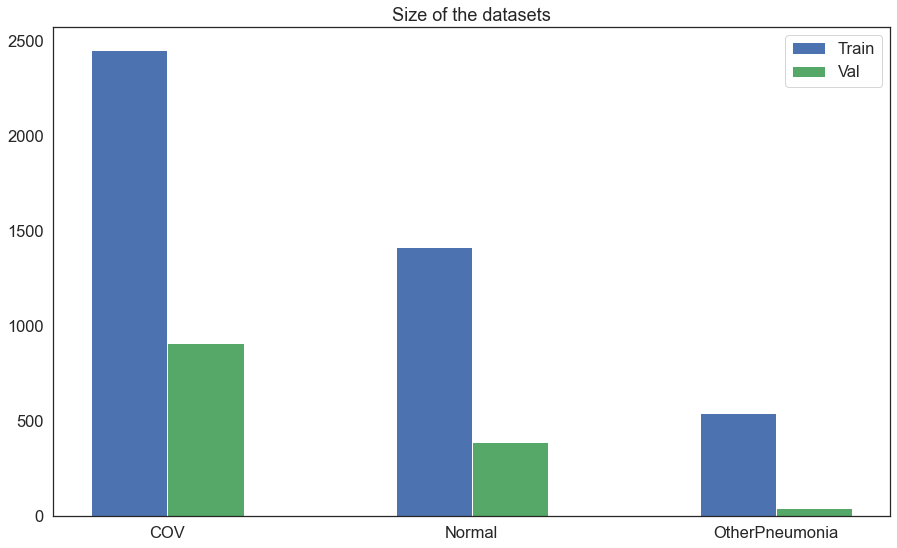

In [42]:
plt.figure(figsize=(15,9))
for i, label in enumerate(classes):
    plt.bar(i, labels_cnt_train[i], width=0.25, color='b', label='Train')
    plt.bar(i+0.25, labels_cnt_val[i], width=0.25, color='g', label='Val')

plt.title('Size of the datasets')
plt.xticks([0.125,1.125,2.125], classes)
plt.legend(['Train', 'Val']);

In [43]:
sizes_train = []
sizes_val = []

for path in files_paths_train:
    img = Image.open(path)
    sizes_train.append(img.width)

for path in files_paths_val:
    img = Image.open(path)
    sizes_val.append(img.width)

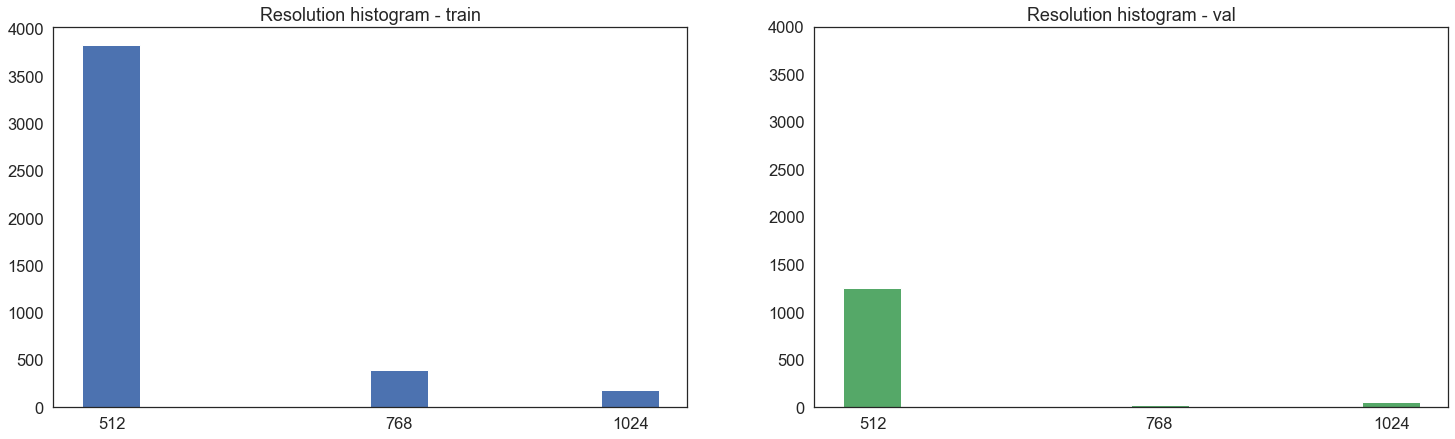

In [44]:
plt.figure(figsize=(25,7))
plt.subplot(1,2,1)
plt.hist(sizes_train)
plt.title('Resolution histogram - train')
plt.xticks([539, 793, 999], [512, 768, 1024])
plt.subplot(1,2,2)
plt.hist(sizes_val, color='g')
plt.title('Resolution histogram - val')
plt.xticks([539, 793, 999], [512, 768, 1024])
plt.ylim(0, 4000);

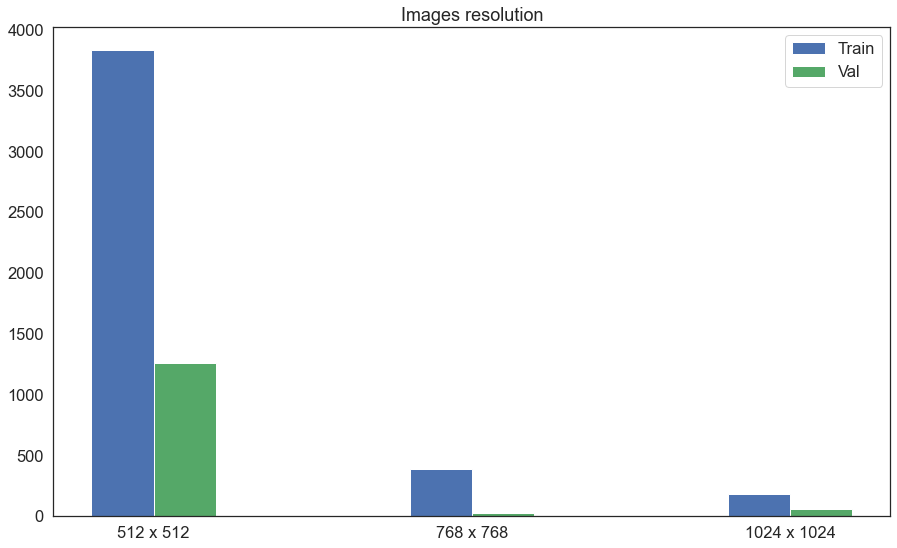

In [45]:
plt.figure(figsize=(15,9))
for i, label in enumerate(set(sizes_train)):
    plt.bar(label-25, sizes_train.count(label), width=50, color='b', label='Train')
    plt.bar(float(label)+25, sizes_val.count(label), width=50, color='g', label='Val')

plt.title('Images resolution')
plt.xticks([512, 768, 1024], ['512 x 512', '768 x 768', '1024 x 1024'])
plt.legend(['Train', 'Val']);

In [14]:
for i, label in enumerate(set(sizes_train)):
    print(label, 'x', label, 'Train:', sizes_train.count(label))
    print(label, 'x', label, 'Val:', sizes_val.count(label))

512 x 512 Train: 3832
512 x 512 Val: 1257
768 x 768 Train: 391
768 x 768 Val: 24
1024 x 1024 Train: 181
1024 x 1024 Val: 60


## Prepare datasets for visualisations

In [12]:
def prepare_X_y(files_paths, files_labels):
    X = []

    for i, path in enumerate(files_paths):
        img = Image.open(path).convert('L')
        img.load()
        if img.width != img_width or img.height != img_height:
            img = img.resize((img_width,img_height))
        
        img_X = np.asarray(img, dtype=np.uint8)
        X.append(img_X)

    X = np.asarray(X)
    y = np.asarray(files_labels)

    return X, y

In [13]:
X_train, y_train = prepare_X_y(files_paths_train, files_labels_train)
X_val, y_val = prepare_X_y(files_paths_val, files_labels_val)

In [14]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4404, 512, 512), (4404,), (1341, 512, 512), (1341,))

## Visualisations

### Examples of each class

COV


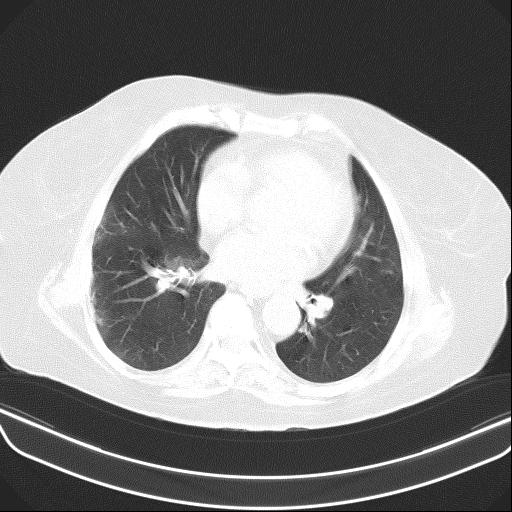

In [18]:
img_ = Image.open(files_paths_train[0])
print(files_labels_train[0])
img_

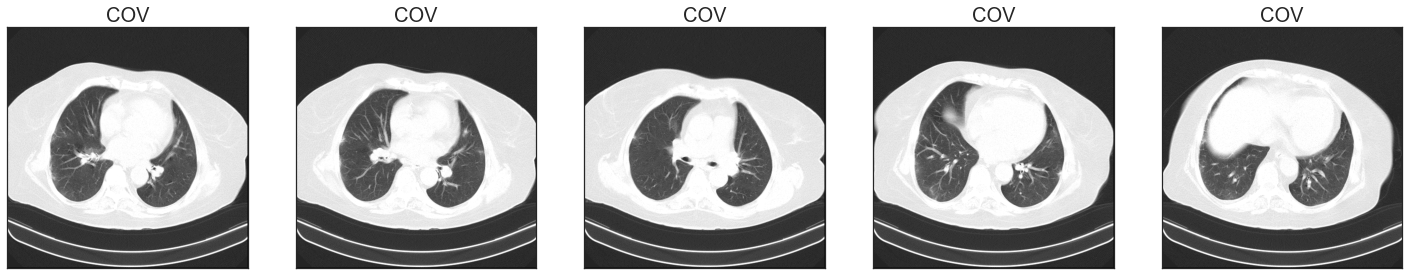

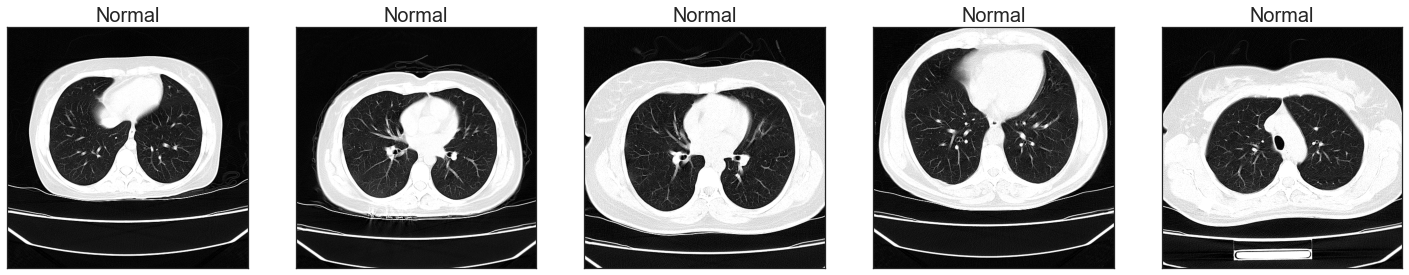

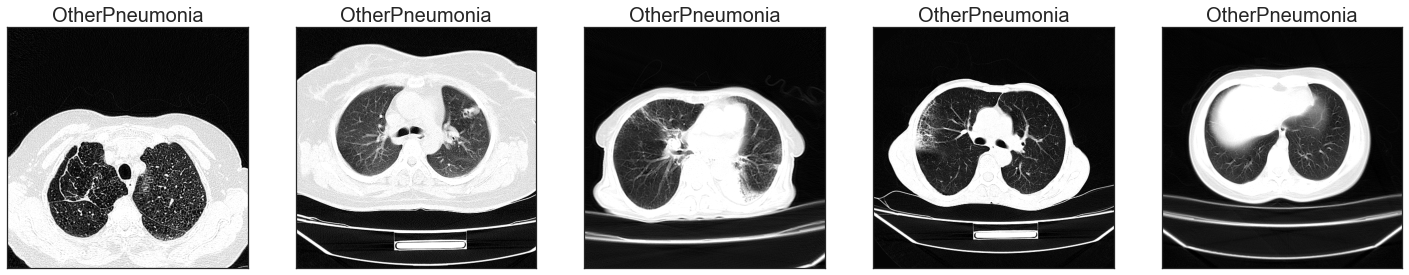

In [19]:
for label in classes:
    images = X_train[y_train == label]
    
    plt.figure(figsize=(25,35))
    for i in range(5):
        plt.subplot(6, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(label, fontsize=20)
        plt.xticks([])
        plt.yticks([])

### Average image per directory

In [46]:
def average_img_per_dir(path):
    i = 0
    plt.figure(figsize=(25,35))

    for root, dirs, files in os.walk(path):
        p = pathlib.Path(root)
        X = []

        if files:
            for file in files:
                img = Image.open(os.path.join(root, file)).convert('L')
                if img.width != img_width or img.height != img_height:
                    img = img.resize((img_width,img_height))
                img_X = np.asarray(img, dtype=np.uint8)
                X.append(img_X)

            X = np.asarray(X, dtype=np.uint8)
            X_sum = np.sum(X, axis=0)
            X_avg = X_sum / X.shape[0]

            plt.subplot(6,5,i+1)
            plt.imshow(X_avg, cmap='gray')
            plt.title(p.parts[-2] + '\n' + p.parts[-1] + ' - ' + 'images: ' + str(len(files)), fontsize=20)
            plt.xticks([])
            plt.yticks([])

            i = i + 1

In [47]:
def average_img_per_class(path):
    for root, dirs, files in os.walk(path):
        p = pathlib.Path(root)
        X = []

        if files:
            for file in files:
                img = Image.open(os.path.join(root, file)).convert('L')
                if img.width != img_width or img.height != img_height:
                    img = img.resize((img_width,img_height))
                img_X = np.asarray(img, dtype=np.uint8)
                X.append(img_X)

    X = np.asarray(X, dtype=np.uint8)
    X_sum = np.sum(X, axis=0)
    X_avg = X_sum / X.shape[0]
        
    return X_avg

#### Training dataset

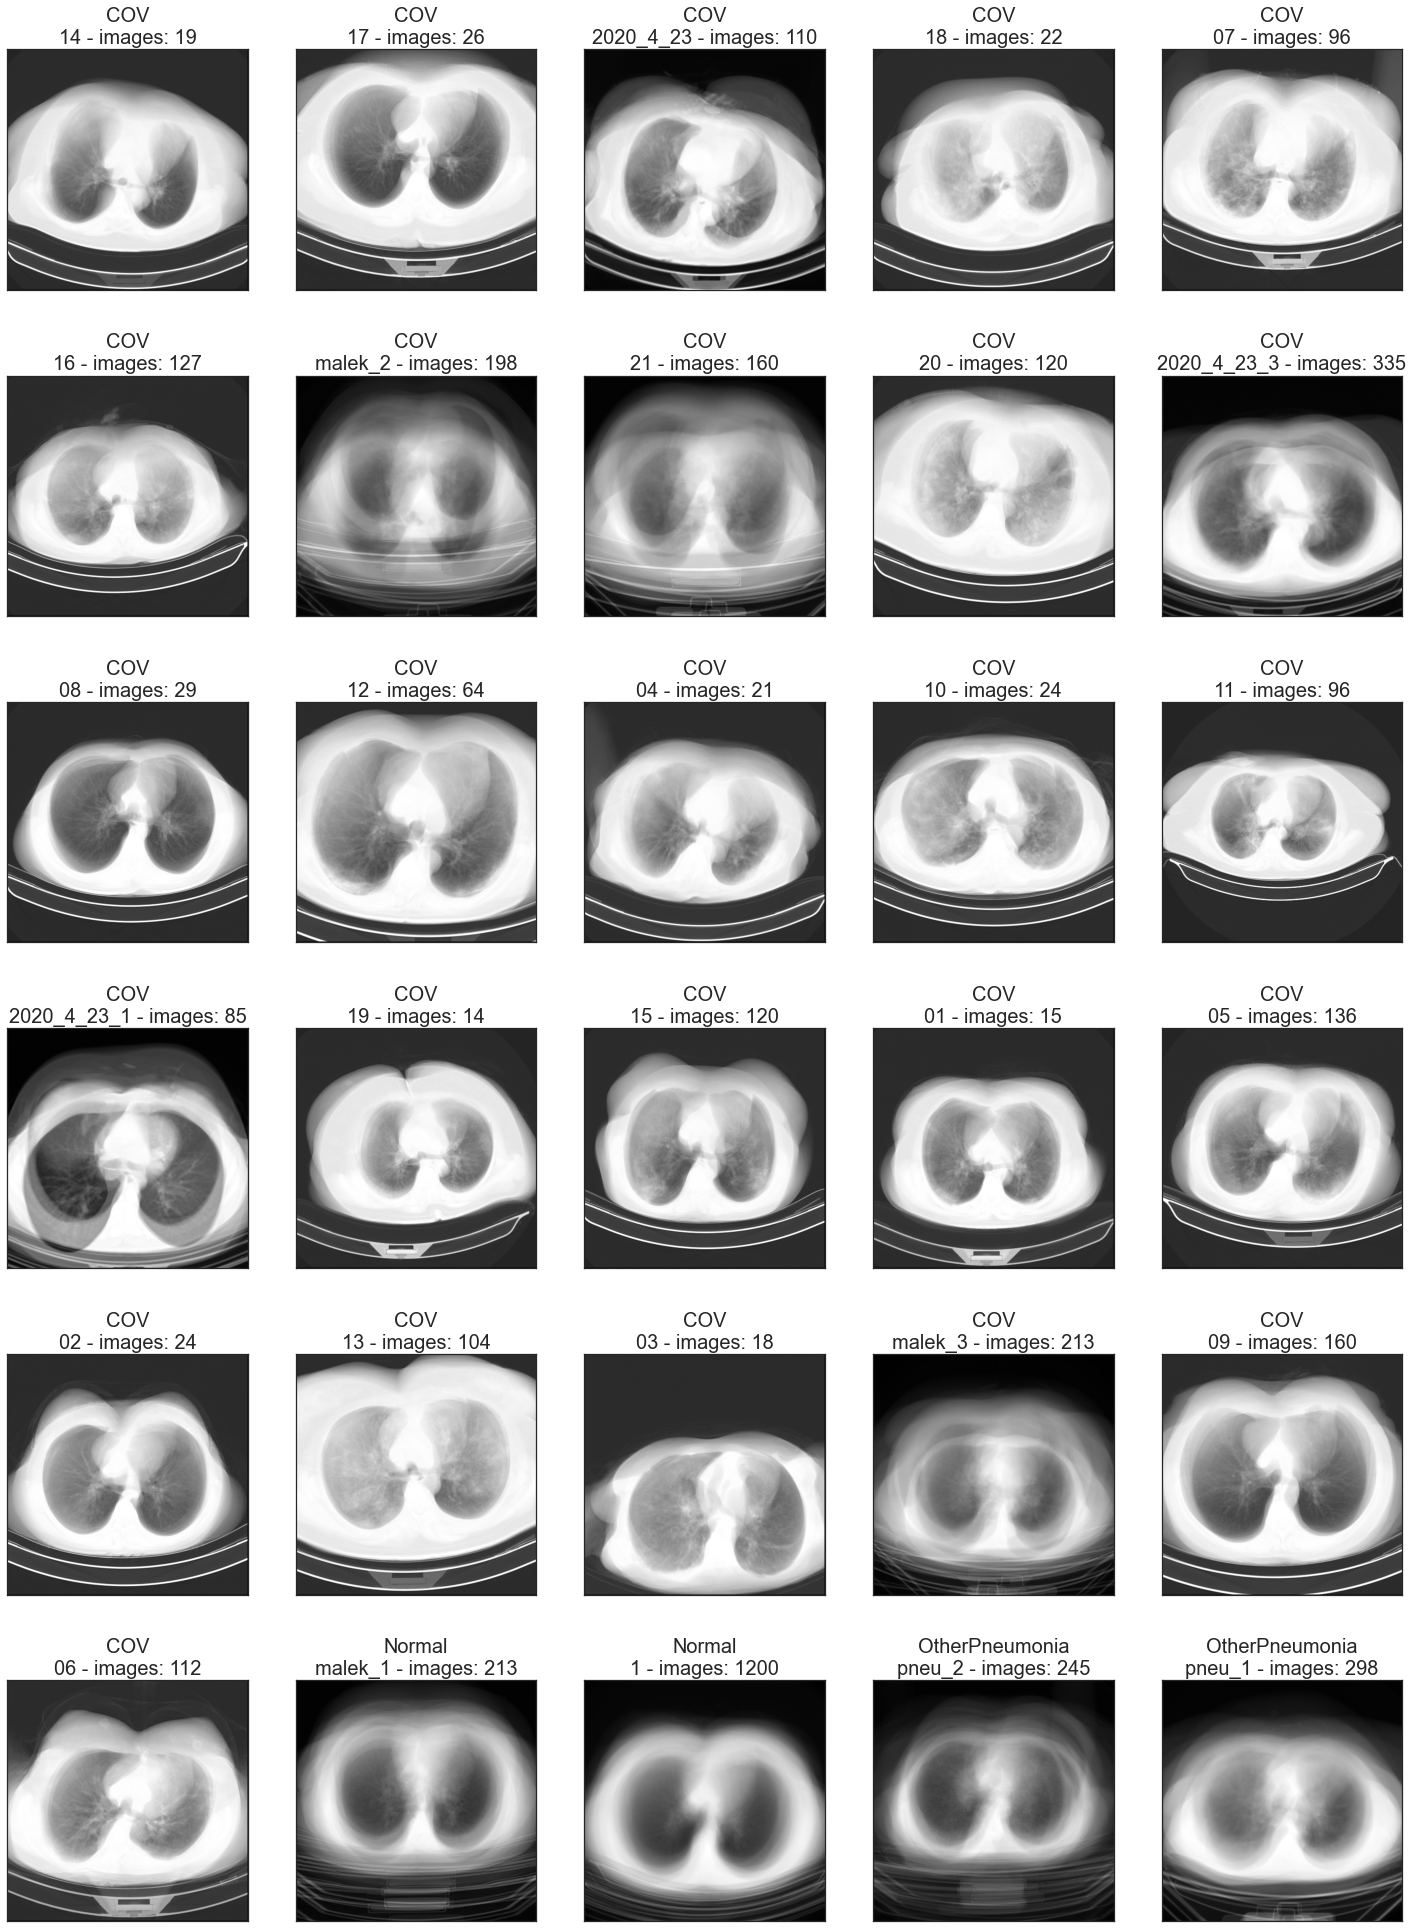

In [48]:
average_img_per_dir(PATH_TRAIN)

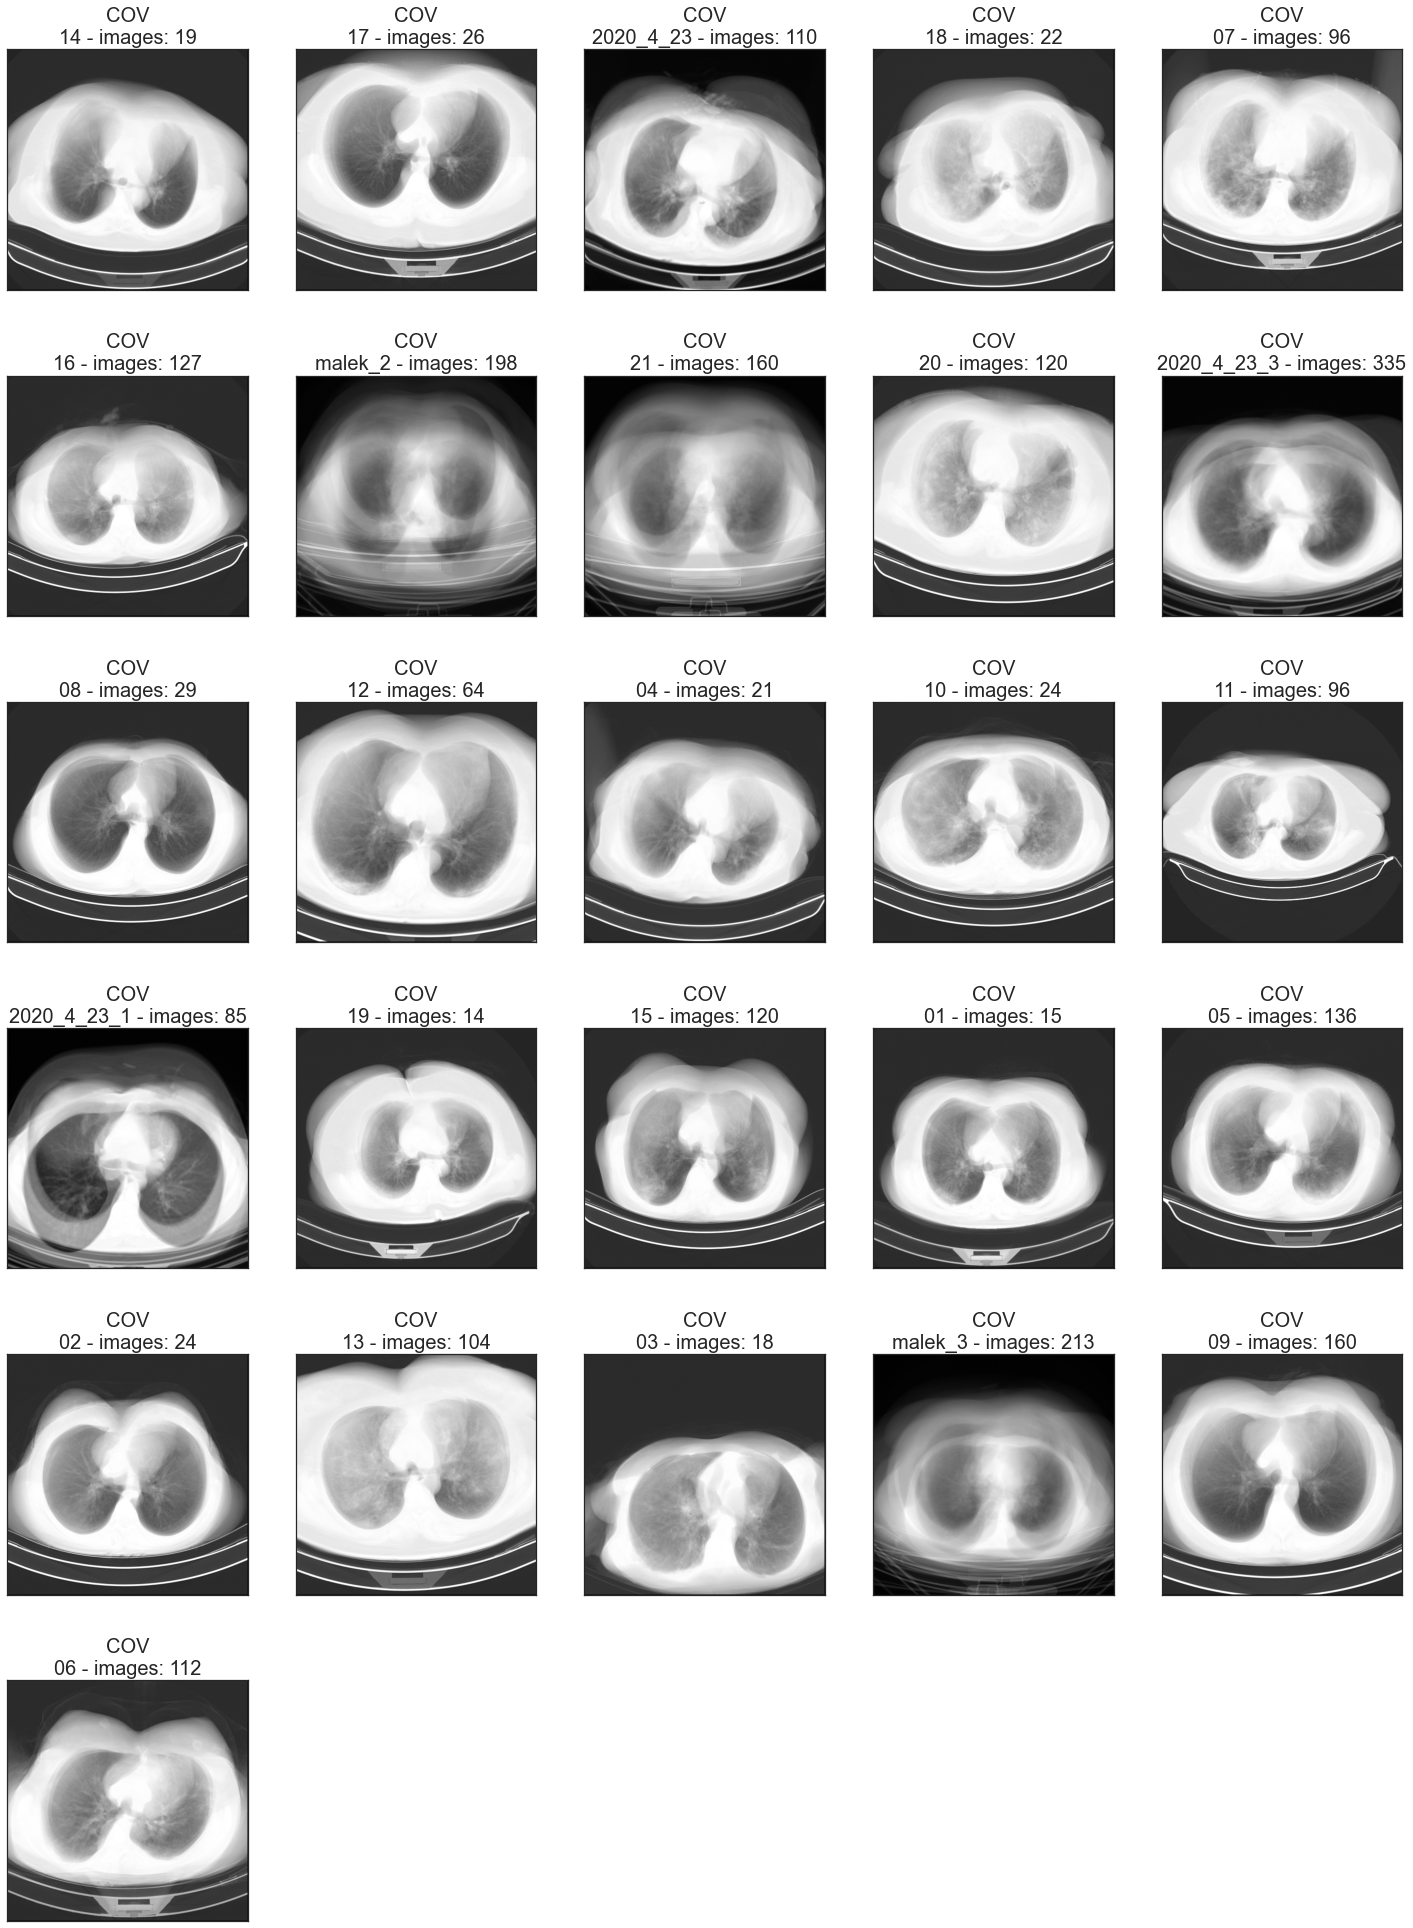

In [49]:
average_img_per_dir(PATH_TRAIN + '/COV')

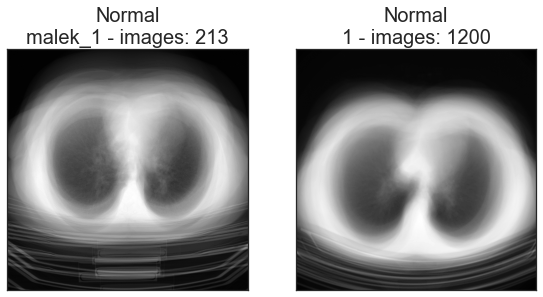

In [50]:
average_img_per_dir(PATH_TRAIN + '/Normal')

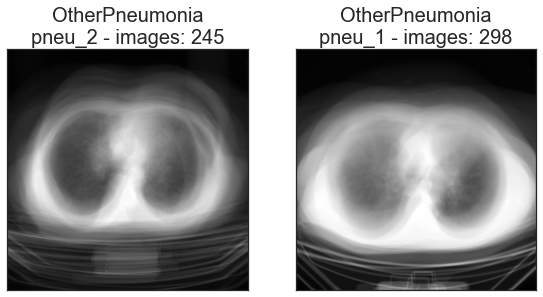

In [51]:
average_img_per_dir(PATH_TRAIN + '/OtherPneumonia')

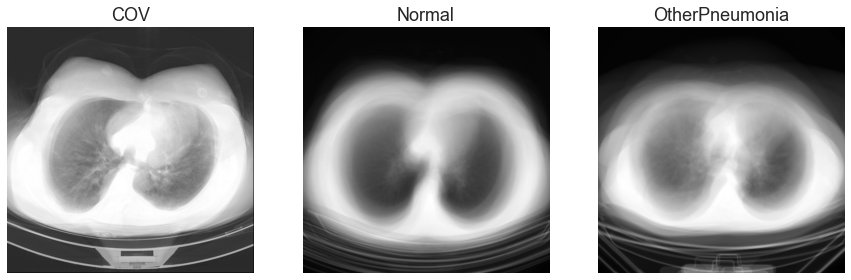

In [29]:
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.imshow(average_img_per_class(PATH_TRAIN + '/COV'), cmap='gray')
plt.title('COV')
plt.axis('off')
plt.subplot(132)
plt.imshow(average_img_per_class(PATH_TRAIN + '/Normal'), cmap='gray')
plt.title('Normal')
plt.axis('off')
plt.subplot(133)
plt.imshow(average_img_per_class(PATH_TRAIN + '/OtherPneumonia'), cmap='gray')
plt.title('OtherPneumonia')
plt.axis('off');

#### Validation dataset

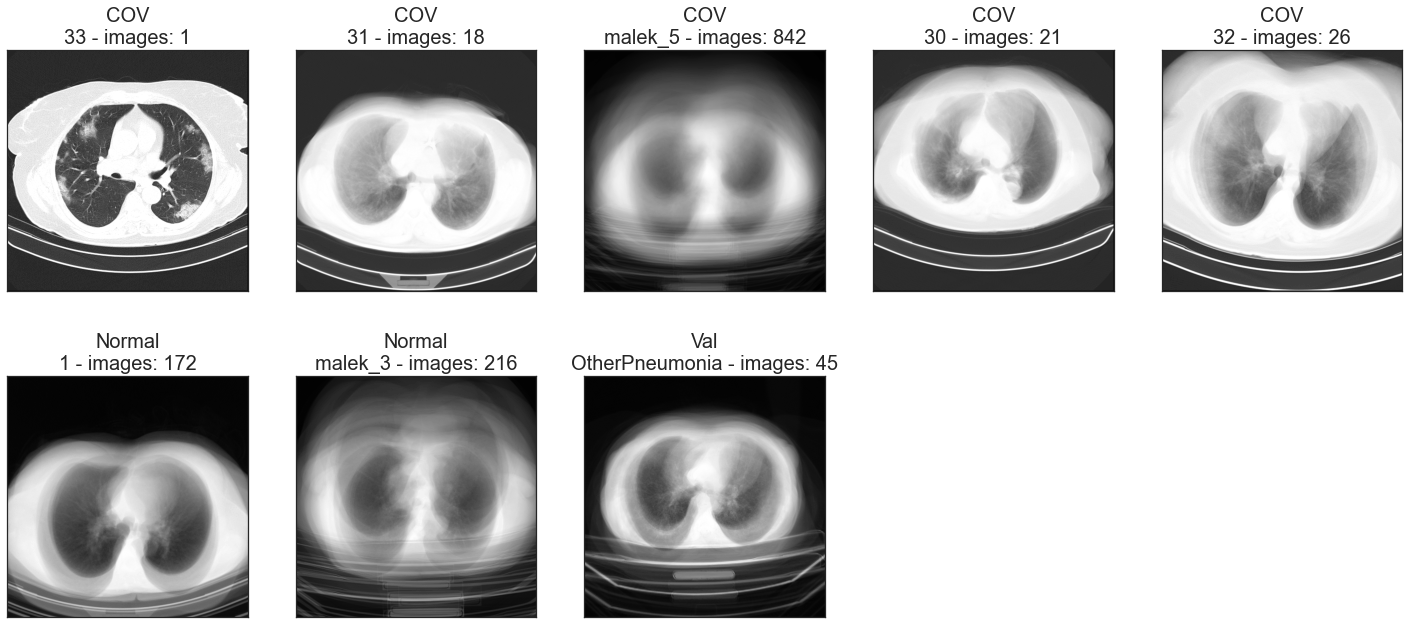

In [53]:
average_img_per_dir(PATH_VAL)

## Example of preprocessed images

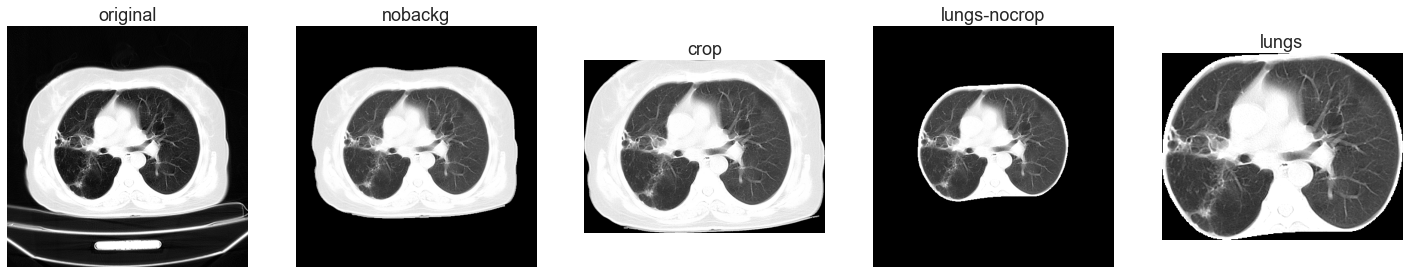

In [22]:
plt.figure(figsize=(25,9))
plt.subplot(151)
plt.imshow(Image.open('Data/CT-COV19/Val/OtherPneumonia/pneu_55.png'), cmap='gray')
plt.title('original')
plt.axis('off')
plt.subplot(152)
plt.imshow(Image.open('Data/CT-COV-Contour/Val/OtherPneumonia/1314.png'), cmap='gray')
plt.title('nobackg')
plt.axis('off')
plt.subplot(153)
plt.imshow(Image.open('Data/CT-COV-Crop/Val/OtherPneumonia/1314.png'), cmap='gray')
plt.title('crop')
plt.axis('off')
plt.subplot(154)
plt.imshow(Image.open('Data/CT-COV-Lungs/Val/OtherPneumonia/1312.png'), cmap='gray')
plt.title('lungs-nocrop')
plt.axis('off')
plt.subplot(155)
plt.imshow(Image.open('Data/CT-COV-Lungs-Crop/Val/OtherPneumonia/1312.png'), cmap='gray')
plt.title('lungs')
plt.axis('off');

## Resolution - input size

In [5]:
def images_resolution(path, title):
    files_paths = []
    resolutions = []
    heights = []
    widths = []

    for root, dirs, files in os.walk(path):
        for file in files:
            files_paths.append(root + '/' + file)
            
    for path in files_paths:
        img = Image.open(path)
        resolutions.append(str(img.height) + ' x ' + str(img.width))
        heights.append(img.height)
        widths.append(img.width)

    print('Height ', max(set(heights), key=heights.count))
    print('Width ', max(set(widths), key=widths.count))
    
    df_dictionary = {'resolution': resolutions, 'height': heights, 'width': widths}
    df = pd.DataFrame(df_dictionary)
    
    plt.figure(figsize=(20,7))
    plt.suptitle(title, fontsize=20)
    
    plt.subplot(121)
    df['height'].hist(bins=1000)
    plt.xlabel('height', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.subplot(122)
    df['width'].hist(bins=1000)
    plt.xlabel('width', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [9]:
PATH_CROP = 'Data/CT-COV-Crop'

Height  328
Width  512


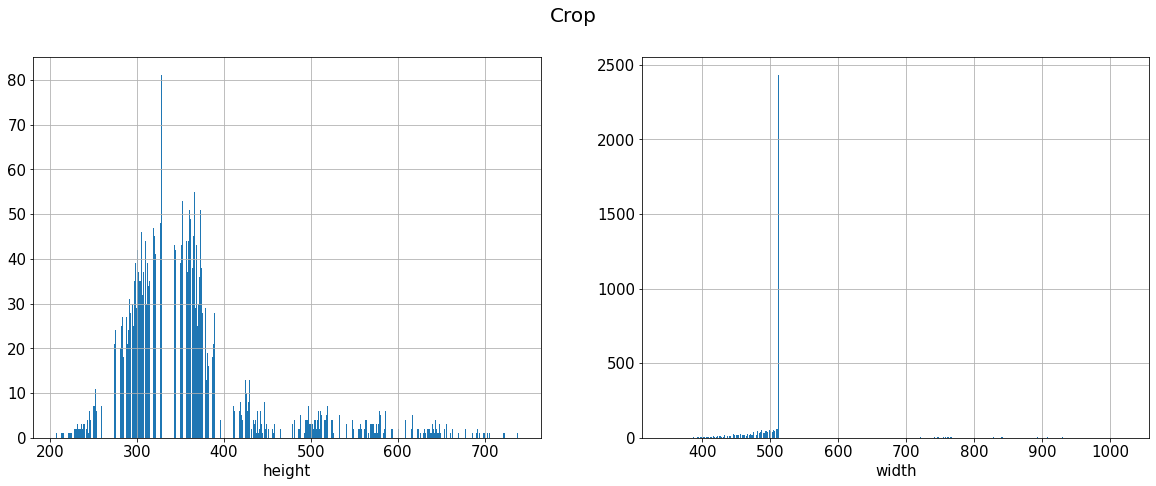

In [10]:
images_resolution(PATH_CROP, 'Crop')

In [7]:
PATH_LUNGS = 'Data/CT-COV-Lungs-Crop'

Height  267
Width  331


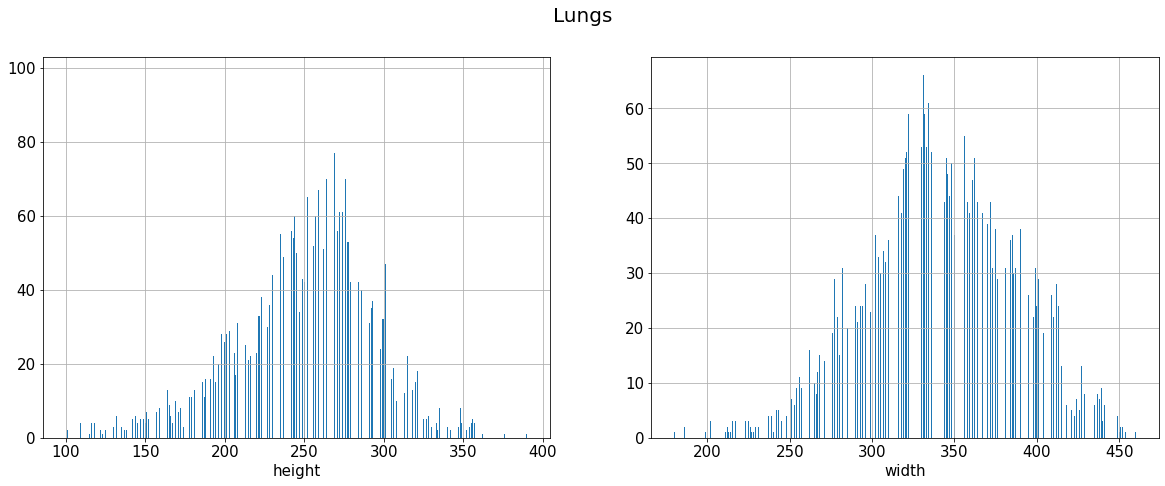

In [8]:
images_resolution(PATH_LUNGS, 'Lungs')